![logo](./img/logo_desafio.png)

# Natural Language Processing with Disaster Tweets Challenge

The [challenge](https://www.kaggle.com/c/nlp-getting-started) consists of a text classification problem. More specifically, it deals with tweets classification, which can be related to real disasters or not. For this, we will use Natural Language Processing (NLP) tools, as well as Machine Learning.

On this notebook, we'll deal with

- "Tweet Tokenizer" for tweets tokenization 
- "Word Vectors"
- SVC and Logistic Regression as classifiers

We'll also explain future improvements at the end of this document

In [1]:
# Importing Libs

import pandas as pd
import numpy as np
import zipfile
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from scipy.sparse import csr_matrix
from tqdm import tqdm

In [2]:
# Loading train and Test datasets

zf = zipfile.ZipFile('./data/nlp-getting-started.zip')
train = pd.read_csv(zf.open('train.csv'))
test = pd.read_csv(zf.open('test.csv'))

In [3]:
train.head(3)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1


In [4]:
test.head(3)

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


The `'Keyword'` column has some potential, as it hasn't much missing values. However, we will start our analysis with solutions focused on the content of documents.

## Default Tokenizer

Tokenizers are tools that helps us transforming sentences into separate words. As an example, the sentence `'Three people died from the heat wave so far'`, picked from the train dataset, is transformed in a list, in which every word is a token. The result is

```['Three', 'people', 'died', 'from', 'the', 'heat', 'wave', 'so', 'far']```


In [7]:
stop_words_nltk = list(stopwords.words('english'))
count_vectorizer = CountVectorizer(stop_words='english')
count_train = count_vectorizer.fit_transform(train['text'].values)

In [8]:
csr_matrix(count_train).toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [10]:
# Picking a sentence to be tokenized

train['text'].values[10]

'Three people died from the heat wave so far'

In [12]:
# Checking the tokenized sentence

word_tokenize(train['text'][10])

['Three', 'people', 'died', 'from', 'the', 'heat', 'wave', 'so', 'far']

## Tweet tokenizer

The tokenizer mentioned above was made with common texts in mind. However, we know that tweets have their own characteristics, such as the use of emojis, hashtags and various abbreviations.

With that in mind, we opted to test the Tweet Tokenizer, a tokenizer in the NLTK library optimized for analyzing Twitter texts.

In [13]:
from nltk.tokenize import TweetTokenizer

def tweet_tokenize_column(df, column):
    """     
        This function gets the Dataframe and the name of a column (String) containing texts (Strings) and returns
        a list of lists containing the tokenized text. It also turns every token to it's lower form and excludes
        stopwords.
        
        Essa funcao recebe o Dataframe e o nome de uma coluna (String) contendo textos (Strings), e retorna uma lista
        de listas contendo o texto tokenizado. A funcao tambem transforma todas as letras maiusculas em minusculas e 
        exclui stopwords.
        
        Input: Pandas DataFrame, String
        Return: Nested List
    """
    
    tweet_tokenizer = TweetTokenizer()
    
    # List of sentences / Lista de sentencas
    list_sent = [tweet_tokenizer.tokenize(sent) for sent in df[column].values]
    
    # List of sentences excluding stopword tokens / Lista de sentencas excluindo stopwords
    list_sent_no_stop = [[token.lower() 
                           for token in sent 
                           if token not in stopwords.words('english')] 
                           for sent in list_sent]
    
    return list_sent_no_stop

In [14]:
# Using the function on train and test datasets

tokenized_sent_train = tweet_tokenize_column(train,'text')
tokenized_sent_test = tweet_tokenize_column(test,'text')

We can see the difference of the tokenizers. On this one, we observe that the tokenization of hashtags were improved.

In [15]:
tokenized_sent_train[:2]

[['our', 'deeds', 'reason', '#earthquake', 'may', 'allah', 'forgive', 'us'],
 ['forest', 'fire', 'near', 'la', 'ronge', 'sask', '.', 'canada']]

In [16]:
tokenized_sent_test[:2]

[['just', 'happened', 'terrible', 'car', 'crash'],
 ['heard',
  '#earthquake',
  'different',
  'cities',
  ',',
  'stay',
  'safe',
  'everyone',
  '.']]

We will create a list of lists containing all tokenized tweets from both training and testing. This is a way to ensure an unified analysis by TF-IDF, which will be explained later.

In [17]:
tokenized_sent_all = tokenized_sent_train + tokenized_sent_test

## TF-IDF

The TF-IDF (Term Frequency - Inverse Document Frequency) is a numerical statistic that gives us the importance of a given word in a set of documents (corpus). Intuitively, a word (token) has a high TF-IDF score if

- It has a high number of occurrences on a single document
e
- It has a low number of ocurrences on all documents

This 'number' is a result of the product of the 'TF' and the 'IDF', which are calculated as follows

\begin{align}
    \operatorname{tf}(t, d)&=\frac{f_{t, d}}{\sum_{t^{\prime} \in d} f_{t^{\prime}, d}}\\\\
    \operatorname{idf}(t, D)&=\log \frac{N}{|\{d \in D: t \in d\}|}\\\\
    \operatorname{tfidf}(t, d, D)&=\operatorname{tf}(t, d) \cdot \operatorname{idf}(t, D)
\end{align}

All terms can be seen in depth on [this link](https://en.wikipedia.org/wiki/Tf%E2%80%93idf).

Now, let's apply the TF-IDF.

In [18]:
# Auxiliar function to bypass the tokenizer, as this step had already been done

def identity_tokenizer(text):
    return text

tfidf_all = TfidfVectorizer(tokenizer=identity_tokenizer, stop_words='english', lowercase=False)    
tfidf_all_fit = tfidf_all.fit_transform(tokenized_sent_all)

tfidf_all.get_feature_names()[1000:1002]


C:\Users\Rafael\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'd', 'e', 'f', 'g', 'h', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


['#hail', '#haildamage']

Note that because TF-IDF was done on all documents both from the train and test datasets, we calculate the scores by treating this aggregated list as a new corpus. This is positive as we will have this score based on more data, tending to give us a more realistic information.


In [19]:
# Creating an unified dataframe. The firs 'n' lines there are data about the train dataset, and on the 'm' following
# lines we have data from the test dataset. 'm' is the number of train documents and 'n' is the number of test 
# documents.

tfidf_all_df = pd.DataFrame(tfidf_all_fit.toarray(), columns=tfidf_all.get_feature_names())

In [20]:
tfidf_all_df.head()

,!,#,##book,##fukushima,##youtube,#0215,#034,#039,#05,#0518,...,ûó,ûócategorically,ûóher,ûókaiserjaegers,ûókill,ûókody,ûónegligence,ûótech,ûówe,ûówere
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
# Splitting the aggregated dataframe into train and test

tfidf_train_df = tfidf_all_df[:len(train)]

tfidf_test_df = tfidf_all_df[len(train):]


In [23]:
# Including target column on the TF-IDF train dataset

tfidf_train_df["target_column"] = train['target']

<ipython-input-23-bd25f1a68171>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tfidf_train_df["target_column"] = train['target']


## Classifiers

### Logistic Regression

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score

X = tfidf_train_df.drop("target_column", axis=1)
y = tfidf_train_df["target_column"]

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=16)

clf = LogisticRegression(random_state=16)

scores_logistic = cross_val_score(clf, X, y, cv=5)

In [25]:
scores_logistic.mean()

0.7047231974377979

In [26]:
from sklearn.metrics import accuracy_score

clf.fit(X,y)

y_pred = clf.predict(X)

print('Training accuracy is {}'.format(accuracy_score(y, y_pred)))

Training accuracy is 0.8903191908577434


We noticed a considerable gap between the cross-validation scores and the accuracy score. We note that this may have to do with overfit, when we train on the entire training dataset, and underfit when we separate the training and testing, datasets as we train with much smaller data.

The submission to Kaggle gave us a public score of 78,547%

In [27]:
# Submission 0.78547

sample_submission = pd.read_csv(zf.open('sample_submission.csv'))

y_sub = clf.predict(tfidf_test_df)

In [28]:
sub = sample_submission.copy()
sub['target'] = y_sub
sub.set_index('id',inplace=True)

In [29]:
sub.head()

,target
id,
0,1
2,0
3,1
9,0
11,1


In [30]:
sub.to_csv("./submissions/sub_01.csv")

# Feature Selection

As a way to try to reduce the overfit and improve the performance of our classifier, we chose to use the $\chi^{2}$ and Mutual Information scores in order to select the most "important" variables for our model, reducing also the dimensionality of the problem.

In [31]:
from sklearn.feature_selection import mutual_info_classif, chi2

# mi = mutual_info_classif(tfidf_train_df_int.drop("target_column", axis=1), tfidf_train_df_int["target_column"])
# mi = pd.Series(mi)
# mi.index = intersect_columns
# mi.sort_values(ascending=False, inplace=True) 

chi = chi2(X,y)
chi = pd.Series(chi[0])
chi.index = X.columns
chi.sort_values(ascending=False, inplace=True)    


In [32]:
chi[:5]

?             37.196852
california    29.250636
suicide       24.139547
:             24.103232
killed        23.600085
dtype: float64

In [33]:
chi.to_csv("./data/chi.csv")

On the cells below, we have a commented set of codes, which shows us as plots the information about the number of variables selected compared to the cross validation variance and the score itself. With this data, we can have a better understanding about the positive or negative influence of the variable selection on the model.   

In [34]:
# atts = np.linspace(100,10000,100)
# list_scores = []
# list_var = []

# for att in tqdm(atts):
    
#     list_scores.append(cross_val_score(clf, X[chi[:int(att)].index], y, cv=3).mean())
#     list_var.append(cross_val_score(clf, X[chi[:int(att)].index], y, cv=3).var())

In [35]:
# int_atts = [int(att) for att in atts]

# import matplotlib.pyplot as plt
# import seaborn as sns

# sns.set()
# plt.figure(figsize=(14,7))
# sns.lineplot(y=list_scores, x=int_atts)
# # plt.axvline(x=int_atts[np.array(list_scores[5:]).argmax()+5], color='r')
# # plt.xticks(ticks=np.arange(0.00, 0.25, 0.01))
# plt.show()

In [36]:
# sns.set()
# plt.figure(figsize=(14,7))
# sns.lineplot(y=list_var, x=int_atts)
# # plt.axvline(x=int_atts[np.array(list_var[5:]).argmin()+5], color='r')
# # plt.xticks(ticks=np.arange(0.00, 0.25, 0.01))
# plt.show()

In [37]:
# atts = np.linspace(100,10000,100)
# list_scores_over = []

# for att in tqdm(atts):
#     clf.fit(X[chi[:int(att)].index],y)
#     y_pred = clf.predict(X[chi[:int(att)].index])
#     acc = accuracy_score(y, y_pred)
    
#     list_scores_over.append(acc)

In [38]:
# int_atts = [int(att) for att in atts]

# sns.set()
# plt.figure(figsize=(14,7))
# sns.lineplot(y=list_scores_over, x=int_atts)
# # plt.axvline(x=int_atts[np.array(list_scores[5:]).argmax()+5], color='r')
# # plt.xticks(ticks=np.arange(0.00, 0.25, 0.01))
# plt.show()

In [39]:
atts = np.linspace(100,10000,100)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=16)



In [40]:
# list_scores_tts = []

# for att in tqdm(atts):
#     clf.fit(X_train[chi[:int(att)].index],y_train)
#     y_pred = clf.predict(X_test[chi[:int(att)].index])
#     acc = accuracy_score(y_test , y_pred)
    
#     list_scores_tts.append(acc)

In [41]:
# int_atts = [int(att) for att in atts]

# sns.set()
# plt.figure(figsize=(14,7))
# sns.lineplot(y=list_scores_tts, x=int_atts)
# # plt.axvline(x=int_atts[np.array(list_var[5:]).argmin()+5], color='r')
# # plt.xticks(ticks=np.arange(0.00, 0.25, 0.01))
# plt.show()

In [42]:
# int_atts = [int(att) for att in atts]
# int_atts[np.array(list_scores_atts).argmax()]

In [43]:
clf.fit(X_train[chi[:3800].index],y_train)

y_pred = clf.predict(X_test[chi[:3800].index])

acc = accuracy_score(y_test , y_pred)

In [44]:
y_sub_chi = clf.predict(tfidf_test_df[chi[:3800].index])

In [45]:
sub_chi = sample_submission.copy()

sub_chi['target'] = y_sub_chi

sub_chi.set_index('id',inplace=True)

In [46]:
# Chi^2 feature selection submission

sub_chi.to_csv("./submissions/sub_chi.csv")

### Suppor Vector Classifier (SVC)

In [47]:
from sklearn.svm import SVC

clf_svc = SVC()
clf_svc.fit(X_train[chi[:3800].index],y_train)
y_pred = clf_svc.predict(X_test[chi[:3800].index])
acc = accuracy_score(y_test , y_pred)

print('Training accuracy is {}'.format(acc))

Training accuracy is 0.8214051214707814


In [48]:
clf_svc.fit(tfidf_train_df[chi[:3800].index],y)

SVC()

In [49]:
y_sub_svc = clf_svc.predict(tfidf_test_df[chi[:3800].index])

In [50]:
sub_svc = sample_submission.copy()
sub_svc['target'] = y_sub_svc
sub_svc.set_index('id',inplace=True)

sub_svc.to_csv("./submissions/sub_svc_overfit.csv")

In [51]:
# atts = [1000,3000,5000]
# list_scores_svc = []

# for att in tqdm(atts):
#     clf_svc.fit(X_train[chi[:int(att)].index],y_train)
#     y_pred = clf_svc.predict(X_test[chi[:int(att)].index])
#     acc = accuracy_score(y_test , y_pred)
    
#     list_scores_svc.append(acc)

# Word Vectors

Having in mind the solution through tokenization with TF-IDF, let's now move on to another type of abstraction, the Word Vectors. This abstraction allows us to map words as multidimensional vectors, indicating the mapping of that word not only in terms of quantity like TF-IDF, but also taking context into account.

As an example, the image below represents the two most important coordinates of a series of 300 dimension word vectors (which represent words in a given context).

<img src="./img/word_vectors_map.png" alt="Vetor de Palavras" width="600"/>



In [52]:
import spacy 

nlp = spacy.load('en_core_web_lg')

with nlp.disable_pipes():
    train_vecs = pd.DataFrame(np.array([nlp(text).vector for text in train.text])) # doc vectors for training set
    test_vecs = pd.DataFrame(np.array([nlp(text).vector for text in test.text])) # doc vectors for testing set

In [53]:
mi = mutual_info_classif(train_vecs,train.target)
mi = pd.Series(mi)
mi.index = train_vecs.columns
mi.sort_values(ascending=False, inplace=True)    

In [54]:
X_word_vec_train, X_word_vec_test, y_word_vec_train, y_word_vec_test = train_test_split(train_vecs, train.target.values, test_size=0.33, random_state=16)

In [55]:
svc = SVC()

atts = np.linspace(1, 299, 299)
list_scores_svc = []

for att in tqdm(atts):
    svc.fit(X_word_vec_train[mi[:int(att)].index].values, y_word_vec_train)
    y_pred = svc.predict(X_word_vec_test[mi[:int(att)].index].values)
    acc = accuracy_score(y_word_vec_test , y_pred)
    
    list_scores_svc.append(acc)

100%|████████████████████████████████████████████████████████████████████████████████| 299/299 [12:01<00:00,  2.41s/it]


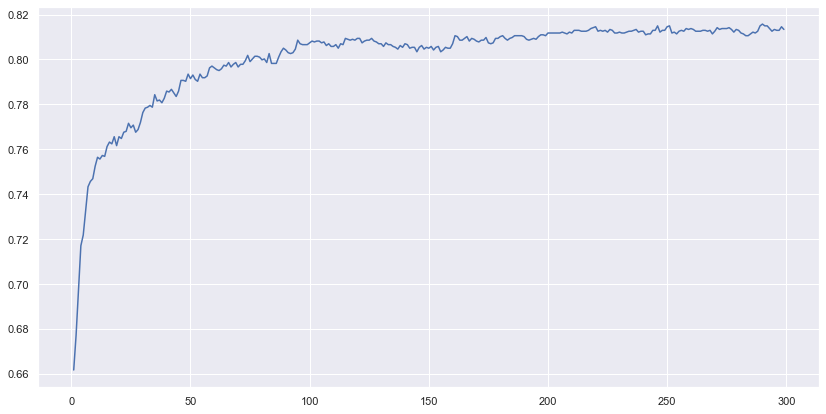

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt

int_atts = [int(att) for att in atts]

sns.set()
plt.figure(figsize=(14,7))
sns.lineplot(y=list_scores_svc, x=atts)
plt.show()

In [57]:
svc.fit(train_vecs.values, train.target)
y_pred = svc.predict(test_vecs.values)

sub_svc = sample_submission.copy()
sub_svc['target'] = y_pred
sub_svc.set_index('id',inplace=True)

sub_svc.to_csv("./submissions/sub_svc_word_vec.csv")

## To-Do

- Test other models ( NaiveBayes, RidgeClassifier, ...)
- Use GridSearch to tune Hyperparameters
